<a href="https://colab.research.google.com/github/sammichini/TopologicalDataAnalysis/blob/main/TDAproject_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q gudhi gudhi[plotting] scikit-learn
# If you prefer seeing install logs, remove the -q flag.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from gudhi import RipsComplex, plot_persistence_diagram, plot_persistence_barcode
%matplotlib inline

## 1. Generate sample points


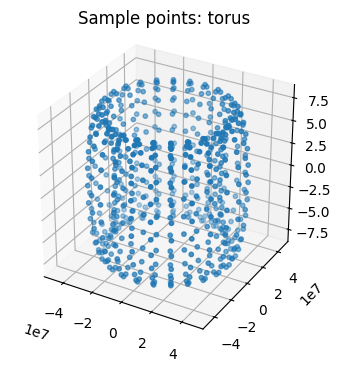

In [ ]:

from mpl_toolkits.mplot3d import Axes3D  # adds 3-D scatter

# --- 1. Helper to draw different shapes -------------------------------
def sample_shape(shape="circle", n=200, **kw):
    """Return an (n, d) NumPy array of points for the requested shape."""
    if shape == "circle":
        θ = np.linspace(0, 2*np.pi, n, endpoint=False)
        return np.c_[np.cos(θ), np.sin(θ)]                          # (n,2)

    if shape == "figure8":
        θ = np.linspace(0, 2*np.pi, n//2, endpoint=False)
        c1 = np.c_[np.cos(θ)-1.2, np.sin(θ)]
        c2 = np.c_[np.cos(θ)+1.2, np.sin(θ)]
        return np.vstack([c1, c2])                                  # (n,2)

    if shape == "sphere":
        v = np.random.normal(size=(n, 3))
        v /= np.linalg.norm(v, axis=1)[:, None]                     # normalise
        return v                                                   # (n,3)

    if shape == "swissroll":
        from sklearn.datasets import make_swiss_roll
        data, _ = make_swiss_roll(n_samples=n, noise=kw.get("noise", 0.0))
        return data[:, [0, 2, 1]]  # re-order to get nice x–z–y layout

    if shape == "torus":
        R = kw.get("R", 25)
        r = kw.get("r", 5)
        p = kw.get("p", 5)
        k = kw.get("k", 6)
        step = p ** k
        scale = kw.get("scale", step * 100)

        # use power-of-p grid size m × m
        m = p ** int(np.round(np.log(np.sqrt(n)) / np.log(p)))
        n = m * m

        u, v = np.meshgrid(
            np.linspace(0, 2*np.pi, m, endpoint=False),
            np.linspace(0, 2*np.pi, m, endpoint=False)
        )

        x = scale * (R + r * np.cos(v)) * np.cos(u)
        y = scale * (R + r * np.cos(v)) * np.sin(u)
        z = scale * r * np.sin(v)

        pts = np.round(np.c_[x.ravel(), y.ravel(), z.ravel()]).astype(int)
        pts = (pts // step) * step  # snap to multiples of p**k
        return pts



    raise ValueError(f"Unknown shape: {shape}")

    #if shape == "torus":
        # kw can supply R (major radius) and r (minor radius)
      #  R, r = kw.get("R", 1.2), kw.get("r", 0.4)
     #   u = np.random.rand(n) * 2*np.pi
     #   v = np.random.rand(n) * 2*np.pi
      #  x = (R + r*np.cos(v))*np.cos(u)
      #  y = (R + r*np.cos(v))*np.sin(u)
      #  z =  r*np.sin(v)
      #  return np.c_[x, y, z]

''' if shape == "torus":
        R, r = 4, 2
        m = 16
        scale = 2  # scale to get integers before rounding

        u_vals = np.linspace(0, 2*np.pi, m, endpoint=False)
        v_vals = np.linspace(0, 2*np.pi, m, endpoint=False)
        u, v = np.meshgrid(u_vals, v_vals)

        u = u.flatten()
        v = v.flatten()

        x = scale * (R + r * np.cos(v)) * np.cos(u)
        y = scale * (R + r * np.cos(v)) * np.sin(u)
        z = scale * r * np.sin(v)

        points = np.round(np.c_[x, y, z]).astype(int)
        return points'''


                                  # (n,3)

# -------------------------------------------------
# helper: fast p-adic valuation  (unchanged)
def fast_p_adic_valuation(arr, p=2, max_depth=20):
    arr = np.abs(np.round(arr).astype(int))
    val = np.zeros_like(arr, dtype=int)
    mask = arr != 0
    for _ in range(max_depth):
        div = (arr % p == 0) & mask
        arr[div] //= p
        val[div] += 1
        mask &= div
    return val
# -------------------------------------------------

def p_adic_distance_matrix(points, p=2, max_depth=20):
    """
    Full p-adic distance matrix using only coordinates
    whose valuation v_p(x) > 0.
    """
    points  = np.asarray(points, dtype=int)
    n       = len(points)
    dist    = np.zeros((n, n), dtype=float)

    for i in range(n):
        diffs   = points[i] - points[i + 1:]                    # (n-i-1, d)
        v_all   = fast_p_adic_valuation(diffs, p=p,
                                        max_depth=max_depth)    # same shape

        # Ignore coordinates whose valuation == 0 OR whose diff == 0.
        mask_use = (diffs != 0) & (v_all > 0)
        v_pos    = np.where(mask_use, v_all, np.inf)            # keep only v>0

        v_min = np.min(v_pos, axis=1)          # inf if no coord had v>0
        v_min[np.isinf(v_min)] = 0             # → distance = 1

        dist_vals = (float(p) ** (-v_min))     # p^{-v}
        dist[i, i + 1:] = dist_vals
        dist[i + 1:, i] = dist_vals

    return dist





# --- 2. Choose the shape and sample points ----------------------------
shape      = "torus"          # ← change to "figure8", "sphere", "torus", …
n_points   = 3125
points = sample_shape("torus")
dist_matrix = p_adic_distance_matrix(points)


# --- 3. Quick visual sanity-check -------------------------------------
fig = plt.figure(figsize=(4, 4))
if points.shape[1] == 2:
    plt.scatter(points[:, 0], points[:, 1], s=10)
    plt.gca().set_aspect('equal')
else:  # 3-D scatter
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=10)
    ax.set_box_aspect([1, 1, 1])          # equal axes
plt.title(f"Sample points: {shape}")
plt.show()




## 2. Build a Vietoris–Rips complex

In [ ]:
from itertools import combinations
import numpy as np



def discrete_metric(x, y):
    return 0 if np.array_equal(x, y) else 1

# --- Print 2-adic distances for sample pairs ---
sample_pairs = [(i, i+1) for i in range(min(len(points)-1, 50))]

print("\nSample 2-adic distances (v₂ in each coordinate & total):")
for i, j in sample_pairs:
    diff = np.abs(points[i] - points[j])
    v2   = fast_p_adic_valuation(diff, p=5)
    d_2  = 5.0 ** (-int(min(v2))) if np.any(diff != 0) else 0.0
    print(f"({i}, {j}) diff = {diff}, v₂ = {v2}, d₂ = {d_2}")



Sample 2-adic distances (v₂ in each coordinate & total):
(0, 1) diff = [ 1484375 11656250        0], v₂ = [7 6 0], d₂ = 1.0
(1, 2) diff = [ 4328125 10921875        0], v₂ = [6 6 0], d₂ = 1.0
(2, 3) diff = [6906250 9500000       0], v₂ = [6 6 0], d₂ = 1.0
(3, 4) diff = [9046875 7484375       0], v₂ = [6 6 0], d₂ = 1.0
(4, 5) diff = [10625000  5015625        0], v₂ = [7 6 0], d₂ = 1.0
(5, 6) diff = [11546875  2203125        0], v₂ = [6 6 0], d₂ = 1.0
(6, 7) diff = [11734375   750000        0], v₂ = [6 6 0], d₂ = 1.0
(7, 8) diff = [11171875  3625000        0], v₂ = [7 6 0], d₂ = 1.0
(8, 9) diff = [9921875 6296875       0], v₂ = [7 6 0], d₂ = 1.0
(9, 10) diff = [8046875 8562500       0], v₂ = [7 6 0], d₂ = 1.0
(10, 11) diff = [ 5656250 10296875        0], v₂ = [6 6 0], d₂ = 1.0
(11, 12) diff = [ 2921875 11390625        0], v₂ = [6 6 0], d₂ = 1.0
(12, 13) diff = [       0 11734375        0], v₂ = [0 6 0], d₂ = 1.0
(13, 14) diff = [ 2921875 11390625        0], v₂ = [6 6 0], d₂ = 1.0
(14, 15

In [ ]:
import numpy as np
from sklearn.metrics import pairwise_distances
import gudhi
from gudhi import RipsComplex, CubicalComplex   # ← import CubicalComplex



# choose metric
metric = "5-adic"          # "euclidean" or "discrete" etc.
max_dimension  = 3
eps_valuation  = 1         # cube-complex filtration value
max_edge_len   = 0.4        # for Euclidean / Rips
# points is your (n,d) integer array, already loaded
# -------------------------------------------------

if metric == "5-adic":
    # --- 1. build edge-valuation vectors in ℕ^d -------------------------
    val_vec = fast_p_adic_valuation(
                  points[:, None, :] - points[None, :, :], p=5
              )[np.triu_indices(len(points), k=20)]          # (m_edges, d)

    # Convert to a cubical grid: we treat each valuation vector as
    # a vertex in ℕ^d with scalar “height” = max(v_i).  Build a
    # CubicalComplex on that regular grid of shape = max(val)+1.
    grid_shape = tuple(val_vec.max(axis=0) + 1)
    grid = np.full(grid_shape, fill_value=np.inf)

    # mark the valuation vectors we actually have with their max value
    for v in val_vec:
        grid[tuple(v)] = max(v)

    # replace ∞ with a large number so Gudhi accepts it
    grid[np.isinf(grid)] = eps_valuation + 1

    cube = CubicalComplex(top_dimensional_cells=grid)
    cube.compute_persistence()

    print("Cubical complex (valuation lattice)")
    print(f"  simplices   : {cube.num_simplices()}")
    print(f"  H0 intervals: {cube.persistence_intervals_in_dimension(0)[:5]}")
    print(f"  H1 intervals: {cube.persistence_intervals_in_dimension(1)[:5]}")
    print(f"  H2 intervals: {cube.persistence_intervals_in_dimension(2)[:5]}")

elif metric == "discrete":
    dist_matrix  = pairwise_distances(points, metric=lambda x, y: 0 if np.array_equal(x, y) else 1)
    simplex_tree = RipsComplex(distance_matrix=dist_matrix,
                               max_edge_length=max_edge_len)\
                   .create_simplex_tree(max_dimension=max_dimension)
    simplex_tree.compute_persistence()
    print("Discrete metric Rips complex contains",
          simplex_tree.num_simplices(), "simplices.")

else:                       # Euclidean, manhattan, cosine, …
    dist_matrix  = pairwise_distances(points, metric=metric)
    simplex_tree = RipsComplex(distance_matrix=dist_matrix,
                               max_edge_length=max_edge_len)\
                   .create_simplex_tree(max_dimension=max_dimension)
    simplex_tree.compute_persistence()
    print("Rips complex contains",
          simplex_tree.num_simplices(), "simplices.")


Cubical complex (valuation lattice)
  simplices   : 13125
  H0 intervals: [[ 6. 16.]
 [10. 16.]
 [ 6. 16.]
 [ 6. 16.]
 [ 6. 16.]]
  H1 intervals: []
  H2 intervals: []


## 3. Compute persistent homology

In [ ]:
# --- after you build the complex ------------------------------------
if metric == "5-adic":
    st = cube                      # cubical complex on valuation lattice
elif metric == "discrete":
    st = simplex_tree              # Rips on discrete metric
else:
    st = simplex_tree              # Rips on Euclidean / manhattan / …

# ensure persistence computed exactly once
st.compute_persistence()

# now this works for every branch
persistence_pairs = st.persistence()

# quick peek
for dim, (birth, death) in persistence_pairs[:10]:
    print(f"dim={dim}  birth={birth:.3g}  death={death:.3g}")


dim=0  birth=6  death=inf
dim=0  birth=6  death=16
dim=0  birth=6  death=16
dim=0  birth=6  death=16
dim=0  birth=6  death=16
dim=0  birth=6  death=16
dim=0  birth=9  death=16
dim=0  birth=9  death=16
dim=0  birth=10  death=16


In [ ]:
import numpy as np
import pandas as pd

# Convert to NumPy array (dimension, birth, death)
diagram_array = np.array([(dim, birth, death) for dim, (birth, death) in persistence_pairs])

# Save as .npy
np.save(f"{shape}_{metric}_persistence.npy", diagram_array)

# Also save as .csv
df = pd.DataFrame(diagram_array, columns=["dimension", "birth", "death"])
df.to_csv(f"{shape}_{metric}_persistence.csv", index=False)

print(f"Saved persistence diagram to '{shape}_{metric}_persistence.npy' and '{shape}_{metric}_persistence.csv'")


Saved persistence diagram to 'torus_5-adic_persistence.npy' and 'torus_5-adic_persistence.csv'


## 4. Visualize persistence diagram and barcode

<Figure size 1500x1500 with 0 Axes>

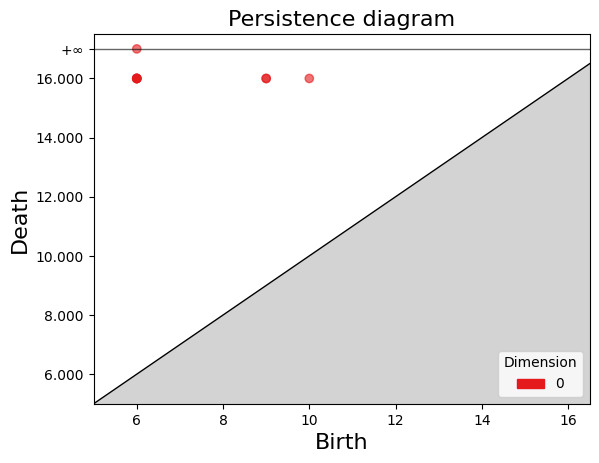

<Figure size 1500x1500 with 0 Axes>

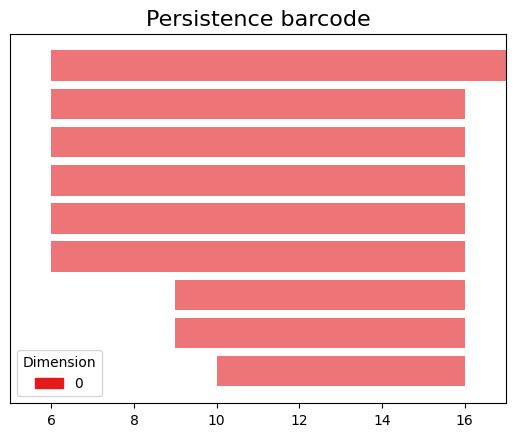

In [ ]:
plt.figure(figsize=(15, 15))
plot_persistence_diagram(persistence_pairs,max_intervals=1500, legend=True)
plt.show()

plt.figure(figsize=(15, 15))
plot_persistence_barcode(persistence_pairs, max_intervals=1500, legend=True)
#ax.set_xlim(0, 2.5)  # Try 1.5 or more if needed
#ax.set_ylim(0, 2.5)  # Try 1.5 or more if needed

plt.show()